In [2]:
import timm
from fastai.vision.all import *

dk_dir = Path("dk_bugs_small")
model_dir = Path("models")

/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(len(get_image_files(dk_dir)))


2526


In [8]:
targets = [parent_label(i) for i in get_image_files(dk_dir)]

def get_dls(bs, size):
    dl = DataBlock(blocks = (ImageBlock,CategoryBlock),
                  get_items = get_image_files,
                  splitter = TrainTestSplitter(stratify=targets),
                  item_tfms=Resize(360, method=ResizeMethod.Crop), 
                  batch_tfms=aug_transforms(mult=2, size=size, min_scale=0.75, flip_vert=True),
                  get_y = parent_label).dataloaders(dk_dir, batch_size = bs)
    return(dl)

In [9]:
dls = get_dls(128, 112)

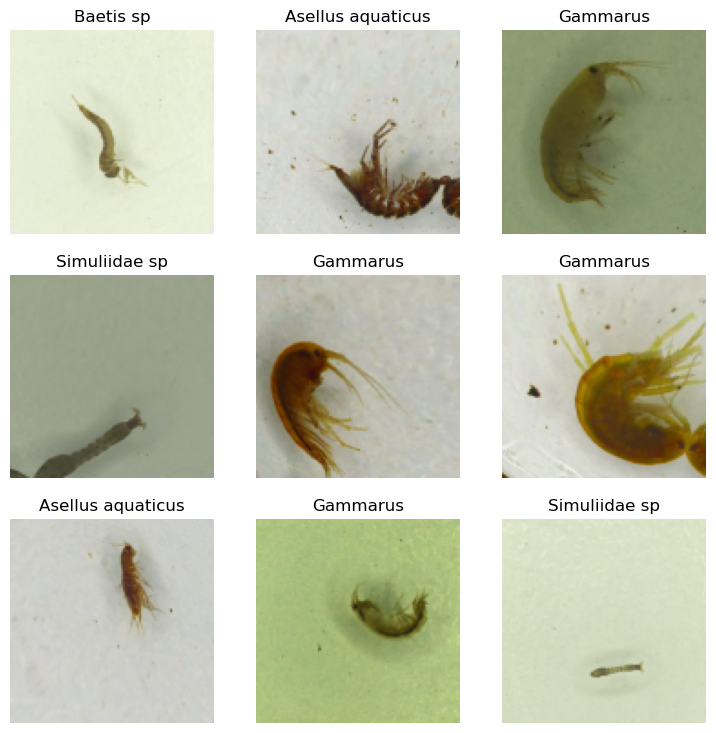

In [12]:
dls.show_batch()

In [13]:
learn = vision_learner(dls, 
                       "efficientnet_b0",
                       pretrained=True,
                       normalize=True,
                       cbs=[MixUp()],
                       #loss_func=LabelSmoothingCrossEntropy(),
                       loss_func=CrossEntropyLossFlat(),
                       metrics=[accuracy, top_k_accuracy]).to_fp16()

In [14]:
learn.fit_one_cycle(10, 3e-3)


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.152630,1.485797,0.662055,0.820158,00:04
1,3.233272,0.755271,0.820158,0.950593,00:03
2,2.680917,0.543837,0.839921,0.974308,00:03
3,2.343705,0.522150,0.861660,0.980237,00:03
4,2.109089,0.429680,0.887352,0.982213,00:03
5,1.921752,0.415794,0.873518,0.982213,00:03
6,1.763900,0.400338,0.877470,0.986166,00:03
7,1.648251,0.374731,0.885375,0.990119,00:03
8,1.547846,0.353967,0.901186,0.992095,00:03
9,1.492098,0.359131,0.889328,0.994071,00:03


In [15]:
learn.dls = get_dls(64, 224)
learn.loss_func = LabelSmoothingCrossEntropy()


In [17]:
learn.fit_one_cycle(20, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.476063,0.833376,0.954545,1.000000,00:05
1,1.475196,0.849874,0.948617,0.996047,00:05
2,1.464488,0.846440,0.956522,0.998024,00:05
3,1.461209,0.841261,0.958498,1.000000,00:05
4,1.462775,0.827644,0.954545,1.000000,00:05
5,1.439765,0.830973,0.958498,0.998024,00:05
6,1.428218,0.818352,0.954545,1.000000,00:05
7,1.412706,0.819359,0.954545,1.000000,00:05
8,1.421127,0.818211,0.960474,0.998024,00:05
9,1.418368,0.816346,0.960474,1.000000,00:05


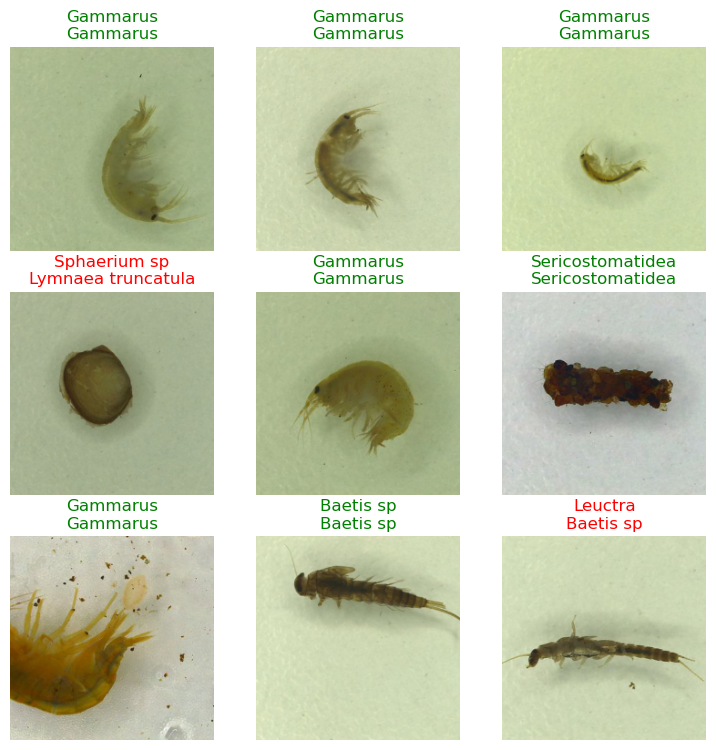

In [21]:
learn.show_results()


In [22]:
learn.export(model_dir/"effnet_b0.export")

In [4]:
learn = load_learner(model_dir/"effnet_b0.export")

In [5]:
import cv2
import torch.functional as F
import torchvision
import torchvision.transforms as transforms


In [6]:
tmp="dk_bugs_preproc/Asellus aquaticus/Asellus aquaticus001.jpg"

In [7]:
pred, pred_idx, probs = learn.predict(tmp)
print(pred)
print(pred_idx)
print(probs)

Gammarus
TensorBase(7)
TensorBase([0.3728, 0.0188, 0.0018, 0.0025, 0.0108, 0.0030, 0.0013, 0.5002,
            0.0046, 0.0034, 0.0060, 0.0018, 0.0062, 0.0020, 0.0064, 0.0052,
            0.0067, 0.0048, 0.0013, 0.0032, 0.0054, 0.0109, 0.0020, 0.0021,
            0.0084, 0.0038, 0.0048])


In [8]:
vocab = learn.dls.vocab
np.save(model_dir/"dk_vocab.npy", vocab)

In [12]:
np.load(model_dir/"dk_vocab.npy").shape

(27,)

In [8]:
# TIMM MODELS ER UDEN IMAGE NORMALIZATION
# define normalization layer
#normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_model = learn.model.cpu()

# define softmax layer
softmax_layer = torch.nn.Softmax(dim=-1) 

# assemble the final model
final_model = nn.Sequential(
    torch_model,
    softmax_layer
)

In [15]:
# generate model input
dummy_input = torch.randn(1, 3, 224, 224, requires_grad=True)

onnx_model_path = model_dir/"effnet_b0.onnx"


In [ ]:

#torch.set_num_threads(1)

#model = models.resnet50(pretrained=True)

# model export into ONNX format
torch.onnx.export(
    final_model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output']
)

In [ ]:
#https://docs.opencv.org/4.x/dc/d70/pytorch_cls_tutorial_dnn_conversion.html



In [16]:
#run onnx model in opencv
input_img = cv2.imread(tmp)
input_img = input_img.astype(np.float32)

scale = 1.0/255.0

input_blob = cv2.dnn.blobFromImage(
    image=input_img,
    scalefactor=scale,
    size=(224, 224),  # img target size
    swapRB=True,  # BGR -> RGB
    crop=True  # center crop
)


In [17]:
opencv_net = cv2.dnn.readNetFromONNX(str(onnx_model_path))


In [18]:
opencv_net.setInput(input_blob)

out = opencv_net.forward()
id_pred = np.argmax(out)
class_pred = vocab[id_pred]

In [23]:
out.squeeze()

array([0.3388794 , 0.01341564, 0.00145238, 0.00188005, 0.00860972,
       0.00223361, 0.001402  , 0.55328774, 0.00348164, 0.0033392 ,
       0.00714775, 0.00154709, 0.00479969, 0.0018164 , 0.00474359,
       0.00458269, 0.00581003, 0.00426262, 0.00131175, 0.00232021,
       0.00518329, 0.01036664, 0.00152637, 0.00216895, 0.00772098,
       0.00306734, 0.00364306], dtype=float32)

In [ ]:
#manual preproc

In [38]:
def center_crop(img):
    
    height, width, _ = img.shape
    min_dim = min(height, width)
    x_min = width//2 - min_dim//2
    x_max = width//2 + min_dim//2
    y_min = height//2 - min_dim//2
    y_max = height//2 + min_dim//2

    img_crop = img[y_min:y_max, x_min:x_max]
    
    return(img_crop)

In [39]:
#def torch_predict(path):
img = cv2.imread(tmp)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_crop = center_crop(img)
img_resize = cv2.resize(img_crop, (224, 224), interpolation = cv2.INTER_LINEAR)
#img_norm = (img_resize - imagenet_stats[0])/imagenet_stats[1]
img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0)/255

In [18]:
img_tensor

tensor([[[[0.7843, 0.7804, 0.7647,  ..., 0.6392, 0.6314, 0.6314],
          [0.7765, 0.7725, 0.7647,  ..., 0.6235, 0.6431, 0.6510],
          [0.7765, 0.7725, 0.7686,  ..., 0.6196, 0.6196, 0.6431],
          ...,
          [0.7451, 0.7412, 0.7529,  ..., 0.7686, 0.7608, 0.7490],
          [0.7412, 0.7412, 0.7529,  ..., 0.7843, 0.7804, 0.7569],
          [0.7451, 0.7451, 0.7529,  ..., 0.7882, 0.7843, 0.7647]],

         [[0.7608, 0.7569, 0.7373,  ..., 0.6196, 0.6196, 0.6196],
          [0.7529, 0.7490, 0.7412,  ..., 0.6039, 0.6314, 0.6392],
          [0.7529, 0.7490, 0.7412,  ..., 0.6000, 0.6078, 0.6314],
          ...,
          [0.7294, 0.7294, 0.7373,  ..., 0.7608, 0.7490, 0.7373],
          [0.7333, 0.7294, 0.7412,  ..., 0.7765, 0.7686, 0.7451],
          [0.7333, 0.7373, 0.7451,  ..., 0.7765, 0.7725, 0.7569]],

         [[0.6980, 0.6941, 0.6824,  ..., 0.5451, 0.5608, 0.5608],
          [0.6902, 0.6863, 0.6784,  ..., 0.5255, 0.5725, 0.5804],
          [0.6902, 0.6863, 0.6784,  ..., 0

In [19]:
final_model.eval()

with torch.no_grad():
    logits = final_model(img_tensor)
    #preds = torch.nn.functional.softmax(logits, dim=1)
    pred_ind = torch.argmax(logits, dim=1)
    label = vocab[pred_ind]

In [20]:
logits

TensorBase([[0.3722, 0.0199, 0.0015, 0.0020, 0.0099, 0.0020, 0.0015, 0.5039,
             0.0043, 0.0028, 0.0072, 0.0017, 0.0045, 0.0023, 0.0051, 0.0056,
             0.0071, 0.0049, 0.0016, 0.0035, 0.0066, 0.0102, 0.0015, 0.0032,
             0.0071, 0.0036, 0.0042]])

In [21]:
from matplotlib import pyplot as plt

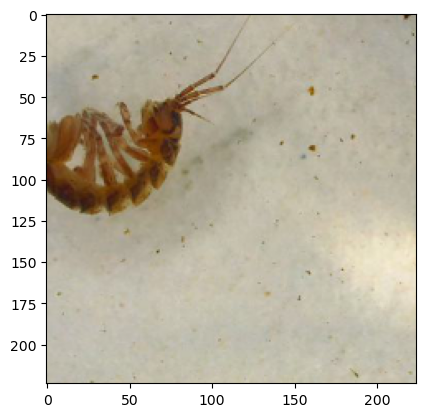

In [43]:
plt.imshow(img_resize)

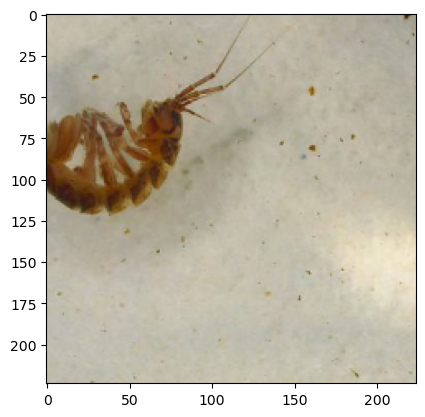

In [42]:
plt.imshow(np.moveaxis(input_blob.squeeze(), 0, -1))

In [ ]:
#export model onnx before using in gui
#https://dev.to/tkeyo/export-fastai-resnet-models-to-onnx-2gj7